In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

import statsmodels.api as sm
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.utils import resample
import seaborn as sns
from matplotlib import pyplot as plt

rd = pd.read_excel('./Resources/combined_phecodex_list.xlsx')
cd = rd.loc[rd['Type'] == 'Common']

def cb(series):
    return series.apply(lambda x: 1 if x > 0 else 0)

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# Optional plotting function
if True:
    import os
    import matplotlib
    import matplotlib.font_manager as font_manager

    font_path = '/sc/arion/projects/GENECAD/Robert/arial.ttf'
    assert os.path.exists(font_path)
    font_manager.fontManager.addfont(font_path)
    prop = font_manager.FontProperties(fname=font_path)

    matplotlib.rc('font', family='sans-serif')
    matplotlib.rcParams.update({
        'font.size': 12,
        'font.sans-serif': prop.get_name(),
        'axes.titlesize': 12
    })

def bootstrap_ci(y_true, y_pred, n_bootstraps=1000, alpha=0.05):
    bootstrapped_scores = {'auroc': [], 'auprc': []}
    indices = np.arange(len(y_true))
    for _ in range(n_bootstraps):
        sampled_indices = resample(indices, replace=True)
        bootstrapped_scores['auroc'].append(roc_auc_score(y_true[sampled_indices], y_pred[sampled_indices]))
        bootstrapped_scores['auprc'].append(average_precision_score(y_true[sampled_indices], y_pred[sampled_indices]))

    ci = {}
    for score_type in bootstrapped_scores:
        sorted_scores = np.sort(bootstrapped_scores[score_type])
        lower = np.percentile(sorted_scores, 100 * alpha / 2)
        upper = np.percentile(sorted_scores, 100 * (1 - alpha / 2))
        mean = np.mean(sorted_scores)
        ci[score_type] = (lower, mean, upper)
    return ci
    
# Helper function to calculate precision@k and NNS
def calculate_precision_at_k(y_true, y_pred, k_values):
    """
    Calculate precision@k and number-needed-to-screen for various k values
    
    Args:
        y_true: True binary labels
        y_pred: Predicted probabilities
        k_values: List of k values to evaluate
        
    Returns:
        DataFrame with k, threshold, precision@k, NNS, and number of true positives
    """
    # Sort by prediction descending
    sorted_indices = np.argsort(-y_pred)
    y_true_sorted = y_true.values[sorted_indices]
    y_pred_sorted = y_pred.values[sorted_indices]
    
    results = []
    for k in k_values:
        if k > len(y_true):
            continue
        top_k_labels = y_true_sorted[:k]
        n_positives = top_k_labels.sum()
        precision_k = n_positives / k
        nns = k / n_positives if n_positives > 0 else np.inf
        
        # Get the threshold (minimum score in top k)
        threshold_at_k = y_pred_sorted[k-1] if k <= len(y_pred_sorted) else y_pred_sorted[-1]
        
        results.append({
            'k': k,
            'threshold': threshold_at_k,
            'precision_at_k': precision_k,
            'nns': nns,
            'n_positives': n_positives
        })
    
    return pd.DataFrame(results)

def calculate_optimal_threshold(y_true, y_pred):
    """
    Calculate optimal threshold by maximizing F1-score
    
    Returns:
        dict with optimal_threshold, precision, recall, f1, and percentile
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    
    # Calculate F1-score for each threshold
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
    
    # Remove NaNs from F1-scores and corresponding thresholds
    valid_idxs = ~np.isnan(f1_scores)
    f1_scores = f1_scores[valid_idxs]
    thresholds = thresholds[valid_idxs]
    precision = precision[:-1][valid_idxs]
    recall = recall[:-1][valid_idxs]
    
    # Find the threshold that maximizes the F1-score
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    return {
        'optimal_threshold': optimal_threshold,
        'precision': precision[optimal_idx],
        'recall': recall[optimal_idx],
        'f1': f1_scores[optimal_idx],
        'percentile': (y_pred < optimal_threshold).mean() * 100
    }

In [2]:
alldata = pd.read_pickle('./Final/ml_input.pkl')

alldata['xscore'] = 0.0
alldata.loc[alldata['phase'] == 0.5, 'xscore'] = 1*0.732*0.548*0.580*0.911
alldata.loc[alldata['phase'] == 1, 'xscore'] = 1*0.732*0.548*0.580
alldata.loc[alldata['phase'] == 2, 'xscore'] = 1*0.732*0.548
alldata.loc[alldata['phase'] == 3, 'xscore'] = 1*0.732
alldata.loc[alldata['phase'] == 4, 'xscore'] = 1

indata = alldata.loc[alldata['drug_gene'] == 1]

ind = indata.groupby('phecode')['indication'].max().reset_index()
ind = ind.loc[ind['indication'] == 1]
indata = indata.loc[indata['phecode'].isin(ind['phecode'])]
print(indata['phecode'].nunique())

#####

clin = ['clingen','eva','gene2phenotype','genomics_england','orphanet','uniprot_literature', 'uniprot_variants']
ot = ['clin_ot','hgmd','gwas_credible_sets','expression_atlas','impc','europepmc']
mantis = ['mantis']
cc = ['cc_common_max_p','cc_rare_max_p','cc_rare_burden_max_p','cc_ultrarare_max_p']


112


## Analysis A: All Protein-Coding Genes (APC)

In [3]:
# Load APC predictions
apc_pdf = pd.read_pickle('./GPS/Main/Predictions/apc_predictions_ot_mantis_cc.pkl')
print(len(apc_pdf), apc_pdf['gene'].nunique(), apc_pdf['phecode'].nunique())

y_true_apc = apc_pdf['indication']
y_pred_apc = apc_pdf['prediction']

# Calculate optimal threshold
apc_optimal = calculate_optimal_threshold(y_true_apc, y_pred_apc)
print(f"APC Optimal Threshold: {apc_optimal['optimal_threshold']:.6f} ({apc_optimal['percentile']:.1f}th percentile)")
print(f"Precision: {apc_optimal['precision']:.3f}, Recall: {apc_optimal['recall']:.3f}, F1: {apc_optimal['f1']:.3f}")

# Calculate how many predictions are above optimal threshold
n_above_optimal = (y_pred_apc >= apc_optimal['optimal_threshold']).sum()
print(f"Number of predictions above optimal threshold: {n_above_optimal:,}")

# Calculate precision@k and NNS for various k values (increase max to cover optimal threshold)
k_values = [50, 100, 250, 500, 1000, 2500, 5000, 10000, 25000]
apc_precision_at_k = calculate_precision_at_k(y_true_apc, y_pred_apc, k_values)

# Calculate baseline precision (overall positive rate)
baseline_precision_apc = y_true_apc.mean()
print(f"\nBaseline precision: {baseline_precision_apc:.4f} ({baseline_precision_apc*100:.2f}%)")

apc_precision_at_k

3021965 19345 161
APC Optimal Threshold: 0.036805 (99.6th percentile)
Precision: 0.053, Recall: 0.113, F1: 0.073
Number of predictions above optimal threshold: 12,275

Baseline precision: 0.0019 (0.19%)


,k,threshold,precision_at_k,nns,n_positives
0,50,0.321043,0.34000,2.941176,17
1,100,0.259684,0.30000,3.333333,30
2,250,0.181303,0.22000,4.545455,55
3,500,0.129632,0.17400,5.747126,87
4,1000,0.089692,0.13500,7.407407,135
5,2500,0.060437,0.09800,10.204082,245
6,5000,0.048135,0.07180,13.927577,359
7,10000,0.039175,0.05490,18.214936,549
8,25000,0.028893,0.03996,25.025025,999


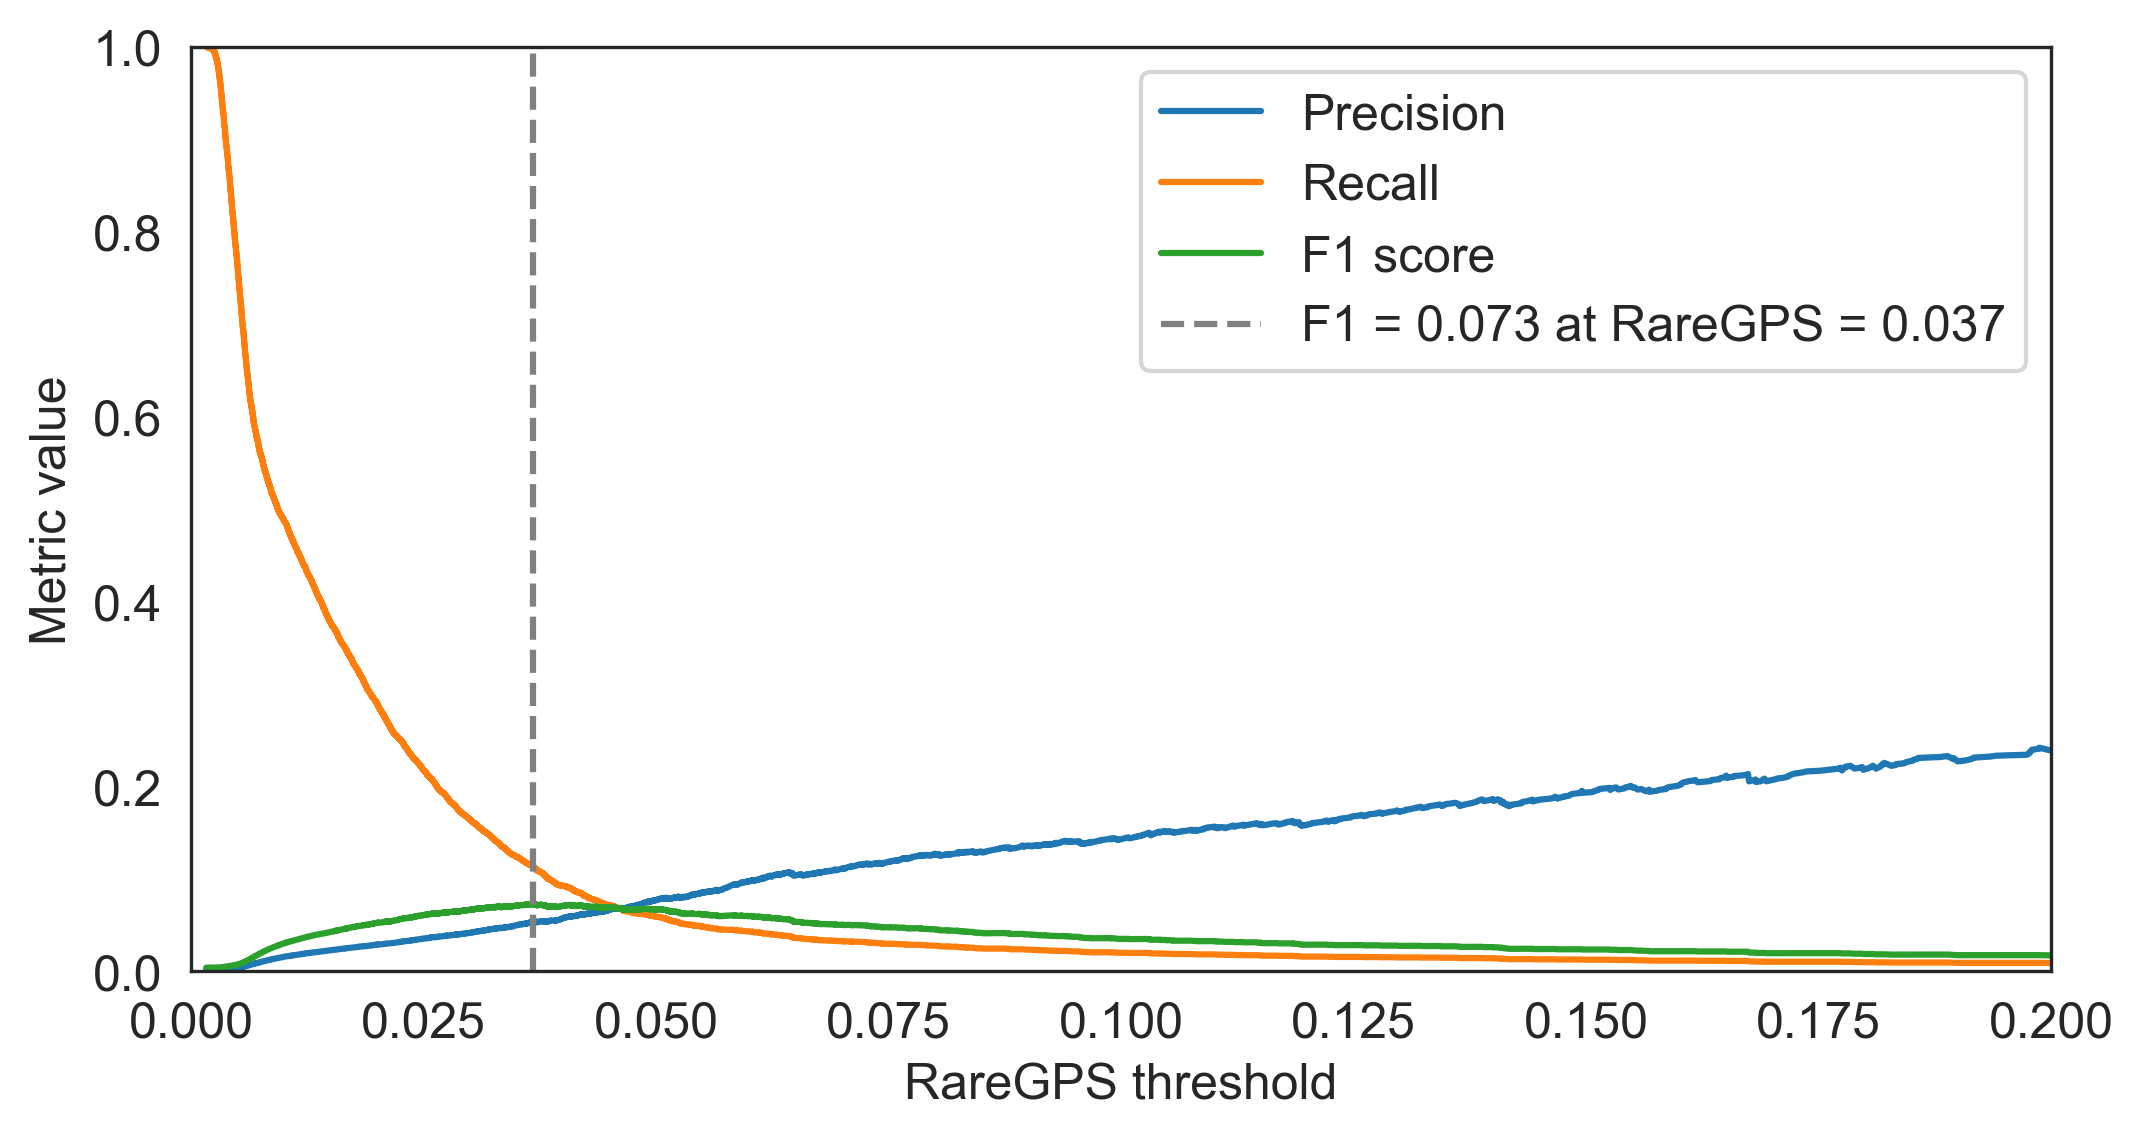

In [4]:
# Plot precision, recall, and F1-score against thresholds for APC
precision_apc, recall_apc, thresholds_apc = precision_recall_curve(y_true_apc, y_pred_apc)

# Calculate F1-score for each threshold
f1_scores_apc = 2 * (precision_apc[:-1] * recall_apc[:-1]) / (precision_apc[:-1] + recall_apc[:-1])

# Remove NaNs
valid_idxs = ~np.isnan(f1_scores_apc)
f1_scores_apc_clean = f1_scores_apc[valid_idxs]
thresholds_apc_clean = thresholds_apc[valid_idxs]
precision_apc_clean = precision_apc[:-1][valid_idxs]
recall_apc_clean = recall_apc[:-1][valid_idxs]

plt.figure(figsize=(8, 4), dpi=300)
sns.set_style('white')

plt.plot(thresholds_apc_clean, precision_apc_clean, label='Precision', linestyle='-')
plt.plot(thresholds_apc_clean, recall_apc_clean, label='Recall', linestyle='-')
plt.plot(thresholds_apc_clean, f1_scores_apc_clean, label='F1 score', linestyle='-')

plt.axvline(x=apc_optimal['optimal_threshold'], color='gray', linestyle='--', 
            label=f"F1 = {apc_optimal['f1']:.3f} at RareGPS = {apc_optimal['optimal_threshold']:.3f}")

plt.xlabel('RareGPS threshold')
plt.ylabel('Metric value')
plt.legend()
plt.xlim([0, 0.2])
plt.ylim([0, 1])

plt.show()

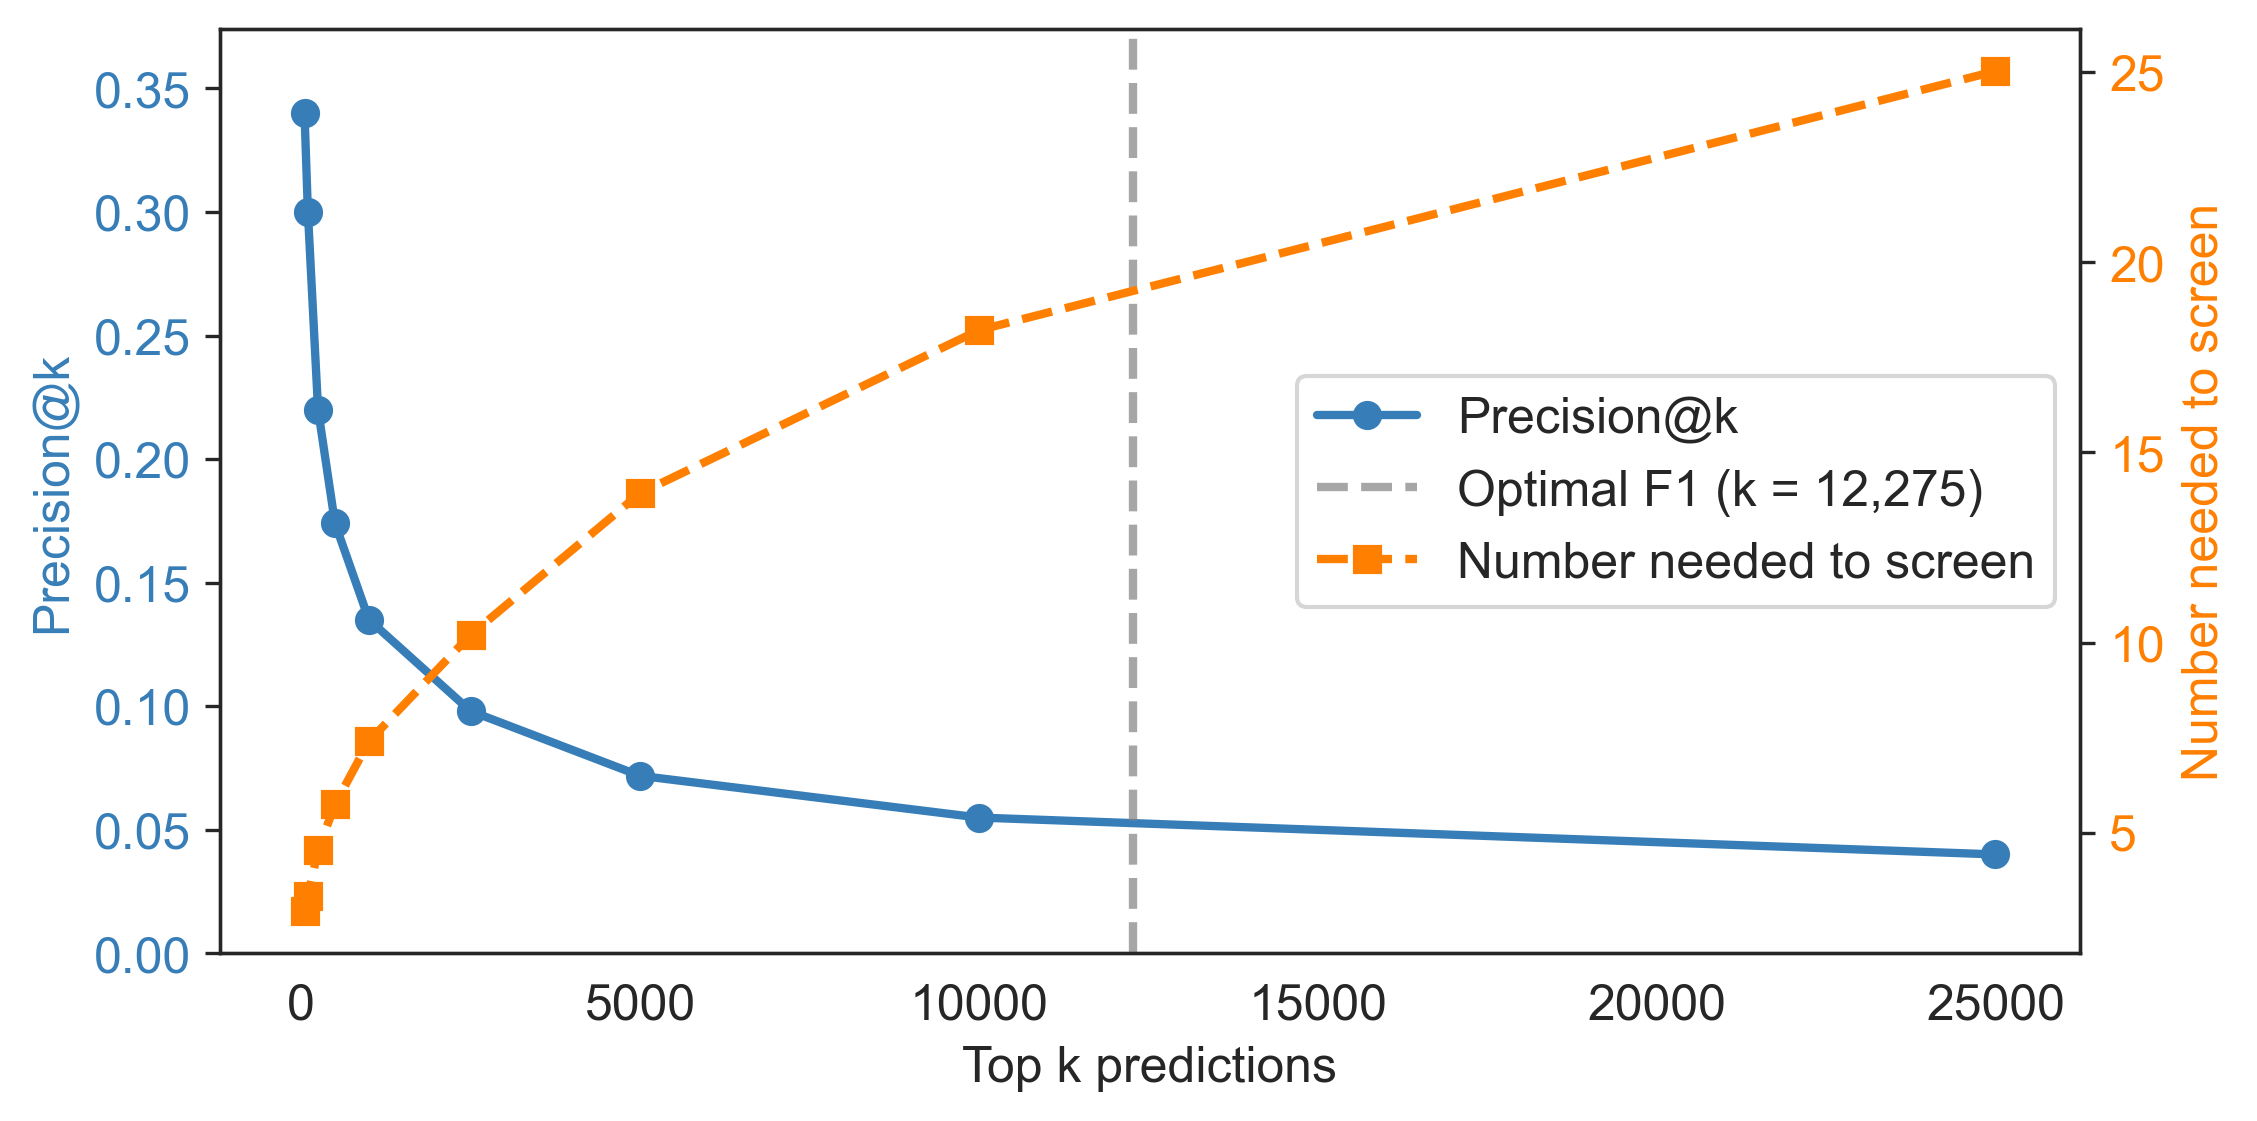


Optimal F1 threshold corresponds to top 12,275 predictions


In [8]:
# Figure A: Combined Precision@k and NNS plot
fig, ax1 = plt.subplots(figsize=(8, 4), dpi=300)
sns.set_style('white')

# Plot precision@k on left y-axis
color1 = CB_color_cycle[0]  # Blue
ax1.set_xlabel('Top k predictions')
ax1.set_ylabel('Precision@k', color=color1)
ax1.plot(apc_precision_at_k['k'], apc_precision_at_k['precision_at_k'], 
         marker='o', color=color1, linewidth=2, markersize=6, label='Precision@k')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_ylim([0, max(apc_precision_at_k['precision_at_k'].max() * 1.1, 0.2)])

# Create second y-axis for NNS
ax2 = ax1.twinx()
color2 = CB_color_cycle[1]  # Orange
ax2.set_ylabel('Number needed to screen', color=color2)
ax2.plot(apc_precision_at_k['k'], apc_precision_at_k['nns'], 
         marker='s', color=color2, linewidth=2, markersize=6, linestyle='--', label='Number needed to screen')
ax2.tick_params(axis='y', labelcolor=color2)

# Add vertical line for optimal threshold
n_above_threshold = (y_pred_apc >= apc_optimal['optimal_threshold']).sum()
ax1.axvline(x=n_above_threshold, color='gray', linestyle='--', linewidth=2, alpha=0.7,
            label=f'Optimal F1 (k = {n_above_threshold:,})')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

plt.show()

print(f"\nOptimal F1 threshold corresponds to top {n_above_threshold:,} predictions")

In [9]:
# Table A: Three pharma use-case scenarios for APC
top_k_values = [100, 1000, 10000]
use_cases = [
    'High-confidence (Animal models, organoids, ~$50K-500K/target)',
    'Moderate (Cell assays, CRISPR, ~$5K-50K/target)',
    'Discovery/Computational (HTS, ~$500-5K/target)'
]

apc_use_case_results = []
for k, use_case in zip(top_k_values, use_cases):
    # Sort predictions and get top k
    sorted_indices = np.argsort(-y_pred_apc)
    top_k_indices = sorted_indices[:k]
    
    y_true_top_k = y_true_apc.iloc[top_k_indices]
    y_pred_top_k = y_pred_apc.iloc[top_k_indices]
    
    n_screened = k
    n_true_positives = y_true_top_k.sum()
    
    # Get the threshold (minimum score in top k)
    threshold = y_pred_top_k.min()
    
    precision = n_true_positives / n_screened if n_screened > 0 else 0
    recall = n_true_positives / y_true_apc.sum() if y_true_apc.sum() > 0 else 0
    nns = n_screened / n_true_positives if n_true_positives > 0 else np.inf
    yield_per_1000 = (precision * 1000)
    
    apc_use_case_results.append({
        'Use Case': use_case,
        'Top k': f'{n_screened:,}',
        'Threshold': f'{threshold:.4f}',
        'Precision (%)': f'{precision*100:.2f}',
        'Recall (%)': f'{recall*100:.2f}',
        'NNS': f'{nns:.1f}',
        'Yield per 1000': f'{yield_per_1000:.1f}'
    })

apc_use_case_table = pd.DataFrame(apc_use_case_results)
print("Table A: APC Use-Case-Specific Performance Metrics\n")
apc_use_case_table

Table A: APC Use-Case-Specific Performance Metrics



,Use Case,Top k,Threshold,Precision (%),Recall (%),NNS,Yield per 1000
0,"High-confidence (Animal models, organoids, ~$5...",100,0.2597,30.00,0.52,3.3,300.0
1,"Moderate (Cell assays, CRISPR, ~$5K-50K/target)","1,000",0.0897,13.50,2.34,7.4,135.0
2,"Discovery/Computational (HTS, ~$500-5K/target)","10,000",0.0392,5.49,9.50,18.2,54.9
